## Environment Setup

1. Install pytorch from http://pytorch.org/ (you don't need to install torchvision).
1. Install MOABB with pip: `pip install moabb`
1. Install latest release of braindecode via pip: `pip install braindecode`
1. mne, matplotlib, scikit-learn and pandas

In [2]:
%matplotlib inline

In [3]:
from braindecode.util import set_random_seeds, np_to_var, var_to_np
import matplotlib.pyplot as plt
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
import numpy as np
from numpy.random import RandomState
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import mne

import start_kits.util.shallow_net
from start_kits.util.utilfunc import get_balanced_batches
from start_kits.util.preproc import plot_confusion_matrix

cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)

/home/ducanh/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu:  True


In [4]:
import torchmetrics
from torchmetrics import CohenKappa, F1Score, Precision, Recall

# Loading MI Data

Use only left- and right-hand labels, the other labels will be listed as other.

In [5]:
# window_size = min(X_src1.shape[2], X_src2.shape[2], X_tgt.shape[2])

# X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_tgt[:100, :, :window_size]))
# y_train = np.concatenate((y_src1, y_src2, y_tgt[:100]))

# X_val = X_tgt[100:150, :, :window_size]
# y_val = y_tgt[100:150]

# X_test = X_tgt[150:, :, :window_size]
# y_test = y_tgt[150:]

np_root = '/home/ducanh/hain/hungp/NeurIPS_BEETL/numpy_data_binary'

X_train = np.load(f'{np_root}/X_train.npy')
y_train = np.load(f'{np_root}/y_train.npy')

X_val = np.load(f'{np_root}/X_val.npy')
y_val = np.load(f'{np_root}/y_val.npy')

X_test = np.load(f'{np_root}/X_test.npy')
y_test = np.load(f'{np_root}/y_test.npy')

window_size = 256

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 15047 trials with 32 electrodes and 256 time samples

Validation: there are 3072 trials with 32 electrodes and 256 time samples

Test: there are 3072 trials with 32 electrodes and 256 time samples


## Training a CNN

In [6]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        # Normalised, you could choose other normalisation strategy
        mean = np.mean(X,axis=1,keepdims=True)
        # here normalise across channels as an example, unlike the in the sleep kit
        std = np.std(X, axis=1, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32) * 1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

New model

In [7]:
in_chans = X_train.shape[1]
labelsize = len(np.unique(y_train))
# model = start_kits.util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)

In [8]:
from braindecode.models import ShallowFBCSPNet, EEGNetv1, EEGNetv4
# model = ShallowFBCSPNet(
#     in_chans = 32,
#     n_classes = 2,
#     input_window_samples=256,
#     final_conv_length='auto',
# )

model = EEGNetv4(
    in_chans = 32,
    n_classes = 3,
    input_window_samples=256,
)


In [9]:
if cuda:
    model.cuda()

End of new model.

In [10]:
labelsize

3

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 0
Train  Loss: 1.09523
Train  Accuracy: 36.0%
Valid  Loss: 1.09896
Valid  Accuracy: 34.3%
model saved
[[508 289 223]
 [465 280 263]
 [540 237 267]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


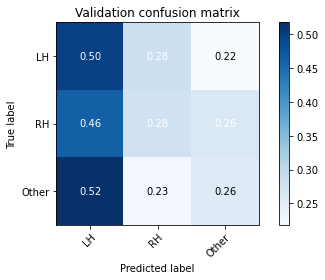

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 1
Train  Loss: 1.06688
Train  Accuracy: 41.4%
Valid  Loss: 1.08875
Valid  Accuracy: 39.3%
model saved
[[512 310 198]
 [432 317 259]
 [486 179 379]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


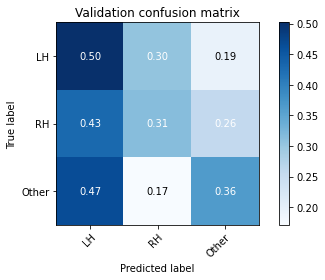

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 2
Train  Loss: 0.99921
Train  Accuracy: 45.9%
Valid  Loss: 1.04077
Valid  Accuracy: 47.6%
model saved
[[475 410 135]
 [355 417 236]
 [353 121 570]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


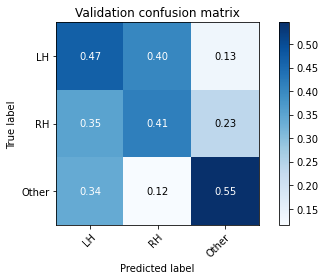

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 3
Train  Loss: 0.94717
Train  Accuracy: 52.3%
Valid  Loss: 0.97846
Valid  Accuracy: 57.4%
model saved
[[407 380 233]
 [242 435 331]
 [ 92  30 922]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


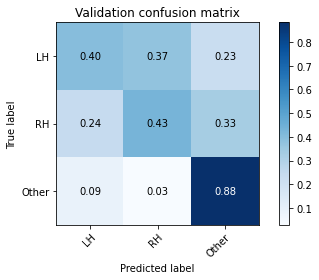

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 4


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.90781
Train  Accuracy: 54.2%
Valid  Loss: 0.95107
Valid  Accuracy: 55.8%
Epoch 5
Train  Loss: 0.88863
Train  Accuracy: 54.6%
Valid  Loss: 0.95416
Valid  Accuracy: 53.7%
Epoch 6
Train  Loss: 0.87721
Train  Accuracy: 54.6%
Valid  Loss: 0.96789
Valid  Accuracy: 52.2%
Epoch 7
Train  Loss: 0.86734
Train  Accuracy: 55.1%
Valid  Loss: 0.99280
Valid  Accuracy: 49.9%
Epoch 8
Train  Loss: 0.85422
Train  Accuracy: 55.8%
Valid  Loss: 1.01587
Valid  Accuracy: 48.6%
Epoch 9
Train  Loss: 0.83909
Train  Accuracy: 56.7%
Valid  Loss: 1.04841
Valid  Accuracy: 47.7%
Epoch 10
Train  Loss: 0.81840
Train  Accuracy: 58.3%
Valid  Loss: 1.07338
Valid  Accuracy: 47.6%
Epoch 11
Train  Loss: 0.80401
Train  Accuracy: 59.5%
Valid  Loss: 1.12022
Valid  Accuracy: 46.5%
Epoch 12
Train  Loss: 0.78445
Train  Accuracy: 61.2%
Valid  Loss: 1.13166
Valid  Accuracy: 48.2%
Epoch 13
Train  Loss: 0.77198
Train  Accuracy: 62.3%
Valid  Loss: 1.15441
Valid  Accuracy: 48.3%
Epoch 14
Train  Loss: 0.76008
Train  Accurac

In [11]:
batch_size = 128
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)

total_epoch = -1
Tlosses, Taccuracies = [], []
Vlosses, Vaccuracies = [], []
highest_acc = 0

savename = "three_classes.pth"

start=time.time()

for i_epoch in range(50):
    total_epoch += 1
    # Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                             batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:, :, :, None]
        batch_y = train_set.y[i_trials]
        # convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
    
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(total_epoch))
    average_acc = []
    average_loss = []
    
    # Here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                                 batch_size=batch_size)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:, :, :, None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp = toutputs.cpu()
                outputs = temp.detach().numpy()
            else:
                temp = toutputs.cpu()
                outputs = np.concatenate((outputs,temp.detach().numpy()))
        net_target = np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': labelsize,
                    'input_time_length': window_size
                }, savename)

                highest_acc=accuracy
                print('model saved')
                plot_confusion_matrix(dataset.y, predicted_labels, 
                                      classes=['LH', 'RH', 'Other'], normalize=True,
                                      title='Validation confusion matrix')
                plt.show()
                # plot_confusion_matrix(dataset.y, predicted_labels, 
                #                       classes=['LH', 'Other'], normalize=True,
                #                       title='Validation confusion matrix')
                # plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end = time.time()

print('time is {}'.format(end-start))

Here we can observe that on training set, the classification accuracy is fairly high, while it is usually not able to generalised well to the new subject directly with this simple strategy, this subject is just a well-performed case for tutorial purpose. Usually validation and test accuracy of a new subject decrease a lot (sometimes 30% or even more). Transfer learning strategies should be used to solve this problem.

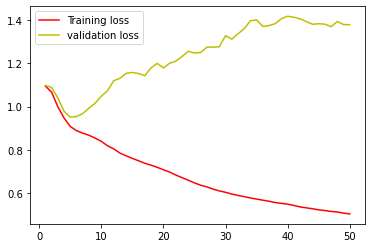

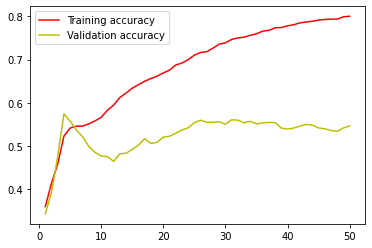

In [12]:
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
plt.legend(('Training loss', 'validation loss'))
plt.show()

plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.show()

testset Loss: 0.97846
testset Accuracy: 57.4%
[[407 380 233]
 [242 435 331]
 [ 92  30 922]]
Normalized confusion matrix


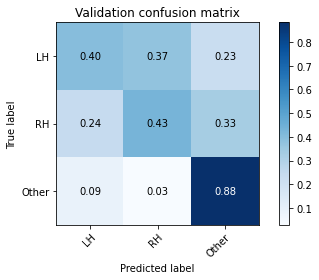

In [13]:
# model = start_kits.util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)

if cuda:
    model.cuda()
checkpoint = torch.load(savename)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                         batch_size=batch_size)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp = toutputs.cpu()
        outputs = temp.detach().numpy()
    else:
        temp = toutputs.cpu()
        outputs = np.concatenate((outputs,temp.detach().numpy()))

net_target = np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, 
                      classes=['LH','RH','Other'], normalize=True,
                      title='Validation confusion matrix')
plt.show()

In [14]:
y_tensor = torch.from_numpy(dataset.y)
y_pred = torch.from_numpy(predicted_labels)

In [15]:
print("Type of a :\n", type(dataset.y))
print("Type of a :\n", type(y_tensor))
# Convert the numpy.ndarray to tensor
print("t:\n", dataset.y)
print("t:\n", y_tensor)

Type of a :
 <class 'numpy.ndarray'>
Type of a :
 <class 'torch.Tensor'>
t:
 [0 0 0 ... 2 2 2]
t:
 tensor([0, 0, 0,  ..., 2, 2, 2])


In [16]:
cohenkappa = CohenKappa(num_classes=3)
cohenkappa(y_tensor, y_pred)

tensor(0.3600)

In [17]:
import pickle
pickle.dump(model, open('pickle_weight.pkl','wb'))